In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("E:/Projects/Learn ML/loan-default-predictor/data/5_additional_features_data.csv")

<Axes: ylabel='Density'>

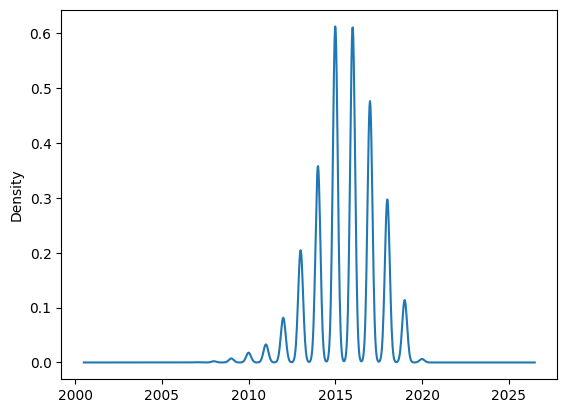

In [3]:
import matplotlib.pyplot as plt

pd.to_datetime(df['issue_d_date']).dt.year.plot.kde()

In [4]:
len(df[df['issue_d_date']>'2017-07-01'])/len(df)

0.21164527352055817

In [5]:
train = df[df['issue_d_date']<='2017-07-01'].drop(columns=['issue_d_date', 'id'])
test = df[df['issue_d_date']>'2017-07-01'].drop(columns=['issue_d_date', 'id'])
data = df.drop(columns=['id'])

In [6]:
train.to_csv("E:/Projects/Learn ML/loan-default-predictor/data/train.csv", index=False)
test.to_csv("E:/Projects/Learn ML/loan-default-predictor/data/test.csv", index=False)
data.to_csv("E:/Projects/Learn ML/loan-default-predictor/data/final_data.csv", index=False)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop(columns=['loan_status']))
X_test = scaler.transform(test.drop(columns=['loan_status']))
y_train = train['loan_status']
y_test = test['loan_status']

In [8]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')

In [9]:
classifier.fit(X_train, y_train)

c:\Users\nevil\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [10]:
y_pred = classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, accuracy_score
print("accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy: 0.6697778060737251
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     60834
           1       0.36      0.60      0.45     17701

    accuracy                           0.67     78535
   macro avg       0.61      0.65      0.61     78535
weighted avg       0.74      0.67      0.69     78535



### not bad, got 60% recall and 36% precision of class 1 with 69% recall of class 0

In [12]:
y_prob = classifier.predict_proba(X_test)[:, 1]

In [13]:
y_prob

array([0.43397297, 0.17857461, 0.65682978, ..., 0.47563409, 0.44694057,
       0.49144965], shape=(78535,))

In [14]:
from sklearn.metrics import precision_recall_curve
import numpy as np

prec, rec, thr = precision_recall_curve(y_test, y_prob)
betas = [0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 0.95, 1, 1, 1.1, 1.125, 1.15, 1.2 , 1.25]

for beta in betas:
    print("beta: ", beta)
    f1 = ((1+beta**2)*prec*rec)/(beta**2*prec+rec)
    best_i = int(np.nanargmax(f1))
    best_thr = thr[best_i]

    y_pred2 = (y_prob>=best_thr).astype(int)
    print("accuracy:", accuracy_score(y_test, y_pred2))
    print(classification_report(y_test, y_pred2))
    print()

beta:  0.1
accuracy: 0.7773222130260393
              precision    recall  f1-score   support

           0       0.78      0.98      0.87     60834
           1       0.55      0.07      0.12     17701

    accuracy                           0.78     78535
   macro avg       0.67      0.53      0.50     78535
weighted avg       0.73      0.78      0.70     78535


beta:  0.2
accuracy: 0.7746609791812568
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     60834
           1       0.50      0.16      0.24     17701

    accuracy                           0.77     78535
   macro avg       0.65      0.56      0.55     78535
weighted avg       0.73      0.77      0.73     78535


beta:  0.5
accuracy: 0.7361940536066722
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     60834
           1       0.41      0.41      0.41     17701

    accuracy                           0.74     78535
   mac

#### with beta=0.95 we are getting 66% recall and 35% precision of class 1

In [15]:
### still try to improve the model with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1],
    'tol': [1e-4, 1e-3, 1e-2],
    'penalty': ['l1'],
    'solver': ['saga']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='recall', n_jobs=-1)

In [16]:
grid_search.fit(X_train, y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.0001, 0.001, ...], 'penalty': ['l1'], 'solver': ['saga'], 'tol': [0.0001, 0.001, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [17]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred_tuned = (y_pred_proba >= 0.173).astype(int)

In [18]:
print("accuracy:", accuracy_score(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))

accuracy: 0.6485770675495002
              precision    recall  f1-score   support

           0       0.86      0.65      0.74     60834
           1       0.35      0.65      0.45     17701

    accuracy                           0.65     78535
   macro avg       0.61      0.65      0.60     78535
weighted avg       0.75      0.65      0.68     78535



##### still get similar results.

In [19]:
## lets run timeseries split to see if results are consistent with older classifier
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
recalls0 = []
recalls1 = []
precisions1 = []
df2=df.copy()
df2['issue_date_duration'] = df2['issue_d_date'].astype('datetime64[s]').astype(int)/10**9
df2 = df2.drop(columns=['issue_d_date'])

In [20]:
sorted_df = df2.sort_values(by='issue_date_duration')
X = sorted_df.drop(columns=['loan_status'])
y = sorted_df['loan_status']

scalled_X = scaler.fit_transform(X)
scalled_X = pd.DataFrame(scalled_X, columns=X.columns)

In [25]:
classifier2 = LogisticRegression(penalty='l1', tol=0.01, C=0.001, solver='saga', class_weight="balanced")
for train_index, val_index in tscv.split(scalled_X):
    X_t, X_v = scalled_X.iloc[train_index], scalled_X.iloc[val_index]
    y_t, y_v = y.iloc[train_index], y.iloc[val_index]
    
    classifier2.fit(X_t, y_t)

    prob = classifier2.predict_proba(X_v)[:, 1]
    prec, rec, thr = precision_recall_curve(y_v, prob)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_thr = thr[np.argmax(f1)]


    pred = (prob >= best_thr).astype(int)
    
    recalls0.append(classification_report(y_v, pred, output_dict=True)['0']['recall'])
    recalls1.append(classification_report(y_v, pred, output_dict=True)['1']['recall'])
    precisions1.append(classification_report(y_v, pred, output_dict=True)['1']['precision'])

    print("Validation Set Results:")
    print("Best threshold:", best_thr)
    print("accuracy:", accuracy_score(y_v, pred))
    print(classification_report(y_v, pred))

print()
print("Average recall for class 0:", sum(recalls0)/len(recalls0))
print("Average recall for class 1:", sum(recalls1)/len(recalls1))
print("Average precision for class 1:", sum(precisions1)/len(precisions1))
print("Average threshold:", sum(thr)/len(thr))

Validation Set Results:
Best threshold: 0.48726889795782846
accuracy: 0.6409190867343639
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     50263
           1       0.29      0.64      0.40     11581

    accuracy                           0.64     61844
   macro avg       0.59      0.64      0.57     61844
weighted avg       0.77      0.64      0.68     61844

Validation Set Results:
Best threshold: 0.4747377521221579
accuracy: 0.650604747429015
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     49061
           1       0.33      0.70      0.45     12783

    accuracy                           0.65     61844
   macro avg       0.61      0.67      0.60     61844
weighted avg       0.77      0.65      0.68     61844

Validation Set Results:
Best threshold: 0.5112256513080993
accuracy: 0.6636860487678675
              precision    recall  f1-score   support

           0       0.88    

#### we got good enough results with logistic regression.

In [31]:
# lets save the model
import joblib

background_data = X.sample(n=200, random_state=42)

artifact_bundle = {
    "model": classifier2,
    "scaler": scaler,
    "threshold": float(0.5039086341803293),
    "model_type": "logistic_regression",
    "background_data": background_data,
    "feature_names": list(X.columns)
}

joblib.dump(artifact_bundle, 'E:/Projects/Learn ML/loan-default-predictor/data/logistic_regression_model.pkl')

['E:/Projects/Learn ML/loan-default-predictor/data/logistic_regression_model.pkl']